In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import math

from numpy.random import multivariate_normal
from numpy.random import binomial
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler  

## A Neural Network Class for Classification

Let's work towards building a class which implements a $n$ layer NN with given activation functions, loss function, and optimization method. We may begin with a simpler implementation.
1. Reference for code structure, see [link](https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter10.html)
2. For back propagation in general, see [link](https://drive.google.com/file/d/1dDw-oyBe8IlExpSEGmaF86e2ytK_k3T6/view?usp=sharing) to handwritten note for derivations.
3. For derivations associated with logistic and softmax regression, see [link](https://drive.google.com/file/d/1Z387JleSrvU0dNJknbgmnj8S4UFpoPLt/view?usp=sharing)

## Some synthetic classification data

[[0.4 0.1]
 [0.1 0.4]]


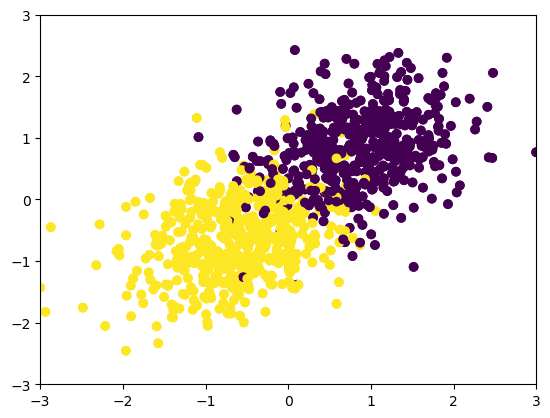

In [2]:
var_x = np.array([[1,0],[0,0]])
var_y = np.array([[0,0],[0,1]])
cov_xy = np.array([[0,1],[1,0]])
basis = [var_x,var_y,cov_xy]

Sigma = np.array((.4,.4,.1))
Sigma = sum([s*b for s,b in zip(Sigma,basis)])
print(Sigma)

s0 = .8
mu_0 = s0*np.array([1,1])
mu_1 = -s0*mu_0

p = .5

num_inputs = 10**3

y = binomial(n=1, p=p, size=num_inputs)

data=[]
for i in range(num_inputs):
    if y[i] == 0:
        x1,x2 = multivariate_normal(mu_0, Sigma, size=1)[0]
    if y[i] == 1:
        x1,x2 = multivariate_normal(mu_1, Sigma, size=1)[0]
    r = [x1,x2,y[i]]
    data.append(r)
data = np.array(data)

df = pd.DataFrame(data=data, columns=["x1", "x2", "y"])

# cm=plt.colormaps.get_cmap('RdYlBu')
for i in set(df.iloc[:,-1]):
    i = int(i)
    plt.scatter(df.iloc[:,0], df.iloc[:,1], c=df.iloc[:,-1])
plt.axis([-3, 3, -3, 3])
plt.show()

# Beginning of a class for NNs

In [3]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

sigmoid = np.vectorize(sigmoid)

def categorical_to_numpy(p):
    # p is array of integer categorical data
    n_samples = len(p)
    p = list(map(int,p))
    n_categories = np.max(p)+1

    base_vec = np.zeros((n_samples, n_categories))
    base_vec[range(n_samples),p] = 1
    return base_vec

In [4]:
class NeuralNetwork: ## n layers of hidden neurons with given activation
    
    def __init__(self, X_data, Y_data, n_layers, n_hidden_neurons, activation=sigmoid, eta=0.01, lam=0, ):
        ## Incoming data is often pd.dataframe
        ## Check type and convert if needed
        self.X_data = X_data
        self.Y_data = Y_data
        
        self.n_samples = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_layers = n_layers
        self.n_hidden_neurons = n_hidden_neurons
        self.eta = eta  ## Learning rate
        self.lam = lam  ## L2 regulator
        
        self.n_categories = len(set(Y_data))
        #self.n_categories = 2
        
        self.activation = sigmoid
        
        self.create_weights_and_biases()
        
        self.softmax_bound = 0
    
    
    def create_weights_and_biases(self):
        self.hidden_weights = []
        self.hidden_biases = []
        for l in range(self.n_layers + 2):
            # the input-hidden layer
            if l == 0:
                self.hidden_weights.append(np.random.randn(self.n_features, self.n_hidden_neurons))
                self.hidden_biases.append(np.zeros(self.n_hidden_neurons) + 0.05)
            # the hidden-hidden layer
            elif l < self.n_layers+1:
                self.hidden_weights.append(np.random.randn(self.n_hidden_neurons, self.n_hidden_neurons))
                self.hidden_biases.append(np.zeros(self.n_hidden_neurons) + 0.05)  
            # the hidden-output layer
            elif l == self.n_layers+1:
                self.hidden_weights.append(np.random.randn(self.n_hidden_neurons, self.n_categories))
                self.hidden_biases.append(np.zeros(self.n_categories) + 0.05) 
    
    def feed_forward_train(self, X):
        # store/update all inputs and activation for use in back propagation
        self.z_collection = []
        self.a_collection = []
        for i in range(self.n_layers + 2):

            # the input-hidden layer
            if i == 0:
                z_temp = np.matmul(X, self.hidden_weights[i]) + self.hidden_biases[i]
                a_temp = self.activation(z_temp)
                
            ## the hidden-hidden layers 
            elif i < self.n_layers+1: 
                z_temp = np.matmul(self.a_collection[i-1], self.hidden_weights[i]) + self.hidden_biases[i]
                a_temp = self.activation(z_temp)
                
            ## the hidden-output layers 
            elif i == self.n_layers+1: 
                z_temp = np.matmul(self.a_collection[i-1], self.hidden_weights[i]) + self.hidden_biases[i]
                exp_term = np.exp(z_temp)
                a_temp = exp_term / (self.softmax_bound + np.sum(np.array(exp_term), axis=1, keepdims=True))             
                
            self.z_collection.append(z_temp)
            self.a_collection.append(a_temp)
            
    def feed_forward_output(self,X):

        for i in range(self.n_layers+2):
            # the input-hidden layer
            if i == 0:
                z_temp = np.matmul(X, self.hidden_weights[i]) + self.hidden_biases[i]
                a_temp = self.activation(z_temp)
            ## the hidden-hidden layers 
            elif i < self.n_layers+1: 
                z_temp = np.matmul(a_temp,self.hidden_weights[i]) + self.hidden_biases[i]
                a_temp = self.activation(z_temp)
            ## the hidden-output layers 
            elif i == self.n_layers+1: 
                z_temp = np.matmul(a_temp,self.hidden_weights[i]) + self.hidden_biases[i]
                
                exp_term = np.exp(z_temp)
                a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))
        return a_temp
        
    def back_propagation(self, X, Y):
        X_data,Y_data=X,Y
        
        ## Transform nominal data to "one-hot" vectors
        #Y_data_to_vector=list( map( lambda i: [ i if j==1 else 0 for j in range(2)], Y_data))
        Y_data_to_vector = categorical_to_numpy(Y_data)

        l = self.n_layers + 1
        self.errors = []
        self.weight_gradients = []
        self.biases_gradients = []
        while l >= 0:
            ## Output layer
            if l == self.n_layers + 1:
                delta_l = self.a_collection[l] - Y_data_to_vector  
                
            ## Hidden layers and Input layers
            elif l >= 0:
                delta_l_plus_1 = self.errors[-1]
                a_l = self.a_collection[l]
                delta_l = np.matmul(delta_l_plus_1, self.hidden_weights[l+1].T)*a_l*(1-a_l)
                
            self.errors.append(delta_l)    
            l -= 1
        
        # Note: error list is reverse ordered - measure index from end
        for l in range(self.n_layers+2):
            if l == 0:
                self.weight_gradients.append(np.matmul(X_data.T, self.errors[-(l+1)] ) )
                self.biases_gradients.append(np.sum(self.errors[-(l+1)], axis=0 ) )
            else:
                self.weight_gradients.append(np.matmul(self.a_collection[l-1].T, self.errors[-(l+1)] ) )
                self.biases_gradients.append(np.sum(self.errors[-(l+1)], axis=0 ) )                
        
        ## Effect of L2 regularization is term lambda*weights in gradient
        self.hidden_weights = [ (1 - self.lam)*s1 - self.eta*s2 for s1,s2 in zip(self.hidden_weights,self.weight_gradients)]
        self.hidden_biases = [ (1 - self.lam)*s1 - self.eta*s2 for s1,s2 in zip(self.hidden_biases,self.biases_gradients)]
        
    def train(self, epochs=10, batch_size=1):
        if batch_size == -1:
            batch_size = self.n_samples
        indices = range(self.n_samples)
        epoch_steps = self.n_samples // batch_size
        
        for i in range(epochs):
            for j in range(epoch_steps):
                random_batch_indices = np.random.choice(indices, size=batch_size, replace=False)
                
                X = self.X_data[random_batch_indices]
                Y = self.Y_data[random_batch_indices]
                
                self.feed_forward_train(X)
                self.back_propagation(X,Y)
                #print(f" (i,j) = {(i,j)}")
                #print(f" error = \n {self.errors[-1]}" )
                
    def predict(self, X):
        probabilities = self.feed_forward_output(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_output(X)
        return probabilities
    

In [5]:
X_data = df.iloc[:,:-1].to_numpy()
Y_data = df.iloc[:,-1].to_numpy()

scaler = StandardScaler()  
scaler.fit(X_data)  
X_data = scaler.transform(X_data)  

# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, train_size=train_size,
                                                    test_size=test_size)


print("Number of training obs: " + str(len(X_train)))
print("Number of test obs: " + str(len(X_test)))

Number of training obs: 800
Number of test obs: 200


In [8]:
n_hidden_neurons = 20
n_layers = 2

eta = 0.001
lam = 0.001

batch_size = 100
epochs = 100

nn = NeuralNetwork(X_data=X_train, Y_data=Y_train, n_layers=n_layers, 
                 n_hidden_neurons=n_hidden_neurons, eta=eta, lam=lam)
nn.feed_forward_train(X_train)
nn.back_propagation(X_train,Y_train)

nn.train(epochs=epochs, batch_size=batch_size)
test_predict = nn.predict(X_test)
print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))

Accuracy score on test set:  0.925


In [19]:
eta_vals = np.logspace(-5, 1, 7)
lam_vals = np.logspace(-5, 1, 7)
# store the models for later use
NN_numpy = np.zeros((len(eta_vals), len(lam_vals)), dtype=object)

# grid search
for i, eta in enumerate(eta_vals):
    for j, lam in enumerate(lam_vals):
        print("Learning rate  = ", eta)
        print("Lambda = ", lam)
        
        nn = NeuralNetwork(X_train, Y_train, eta=eta, lam=lam, 
                            n_hidden_neurons=n_hidden_neurons, n_layers=n_layers)
        nn.train(epochs=epochs, batch_size=batch_size)
        
        NN_numpy[i][j] = nn
        
        test_predict = nn.predict(X_test)
        
        print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))
        print()

Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.49

Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.26

Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.37

Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.545

Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.545

Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.455

Learning rate  =  1e-05
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.895

Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.915

Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.91

Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.545

Learning rate  =  0.0001
Lambda =  0.1
Accuracy score on test set:  0.545

Learning rate  =  0.0001
Lambda =  1.0
Accuracy score on test set:  0.545

Learning rate  =  0.0001
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  0.001
Lambda =  1e-05
Accuracy score on test set:  0.915

Learning rate  =  0.001
Lambda =  0.0001
Accuracy score on test set:  0.905

Learning rate  =  0.001
Lambda =  0.001
Accuracy score on test set:  0.91

Learning rate  =  0.001
Lambda =  0.01
Accuracy score on test set:  0.905

Learning rate  =  0.001
Lambda =  0.1
Accuracy score on test set:  0.545

Learning rate  =  0.001
Lambda =  1.0
Accuracy score on test set:  0.545

Learning rate  =  0.001
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  0.01
Lambda =  1e-05
Accuracy score on test set:  0.915

Learning rate  =  0.01
Lambda =  0.0001
Accuracy score on test set:  0.895

Learning rate  =  0.01
Lambda =  0.001
Accuracy score on test set:  0.915

Learning rate  =  0.01
Lambda =  0.01
Accuracy score on test set:  0.905

Learning rate  =  0.01
Lambda =  0.1
Accuracy score on test set:  0.73

Learning rate  =  0.01
Lambda =  1.0
Accuracy score on test set:  0.455

Learning rate  =  0.01
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  0.1
Lambda =  1e-05
Accuracy score on test set:  0.92

Learning rate  =  0.1
Lambda =  0.0001
Accuracy score on test set:  0.89

Learning rate  =  0.1
Lambda =  0.001
Accuracy score on test set:  0.895

Learning rate  =  0.1
Lambda =  0.01
Accuracy score on test set:  0.895

Learning rate  =  0.1
Lambda =  0.1
Accuracy score on test set:  0.79

Learning rate  =  0.1
Lambda =  1.0
Accuracy score on test set:  0.455

Learning rate  =  0.1
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  1.0
Lambda =  1e-05


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.85

Learning rate  =  1.0
Lambda =  0.0001


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.915

Learning rate  =  1.0
Lambda =  0.001
Accuracy score on test set:  0.895

Learning rate  =  1.0
Lambda =  0.01


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.865

Learning rate  =  1.0
Lambda =  0.1


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.92

Learning rate  =  1.0
Lambda =  1.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.455

Learning rate  =  1.0
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  10.0
Lambda =  1e-05


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  10.0
Lambda =  0.0001


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  10.0
Lambda =  0.001


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  10.0
Lambda =  0.01


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  10.0
Lambda =  0.1


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  10.0
Lambda =  1.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455

Learning rate  =  10.0
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.455



/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_96062/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_96062/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


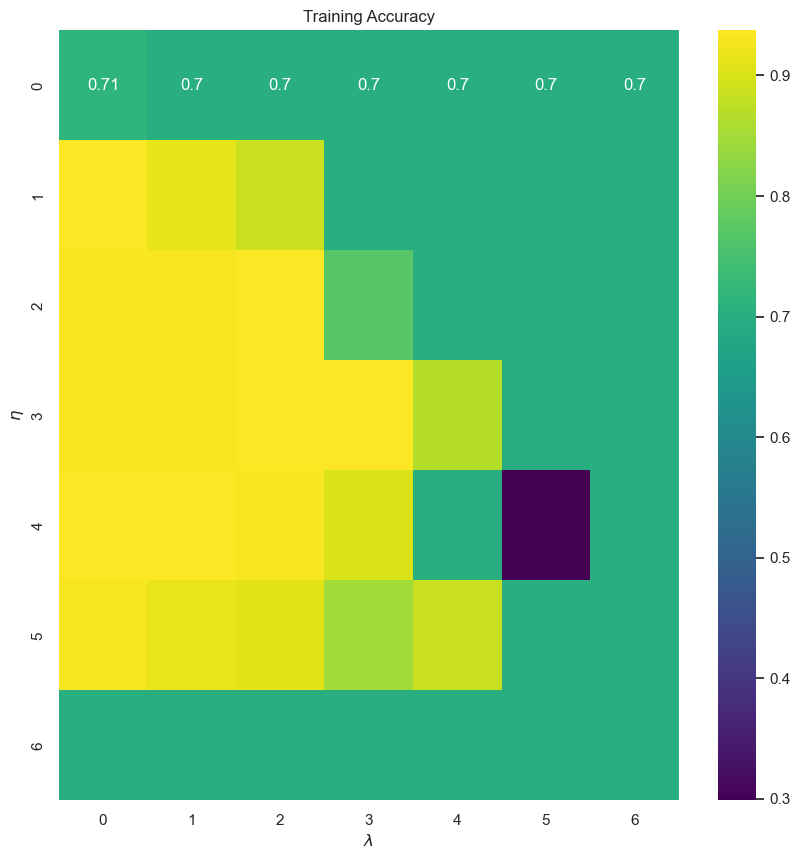

In [12]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lam_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lam_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lam_vals)):
        nn = NN_numpy[i,j]
        
        if not type(nn) == int:
            train_pred = nn.predict(X_train) 
            test_pred = nn.predict(X_test)

            train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
            test_accuracy[i][j] = accuracy_score(Y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

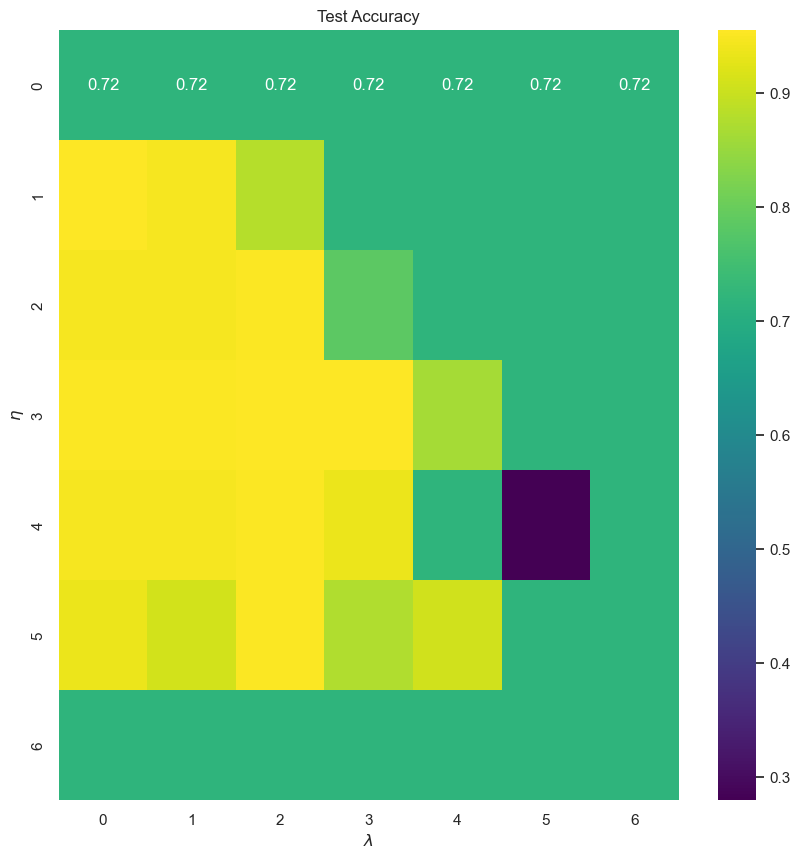

In [13]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

## Using Sklearn's MLPClassifier

In [20]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(50,), activation="logistic", solver="sgd", learning_rate='constant',
                    random_state=1, max_iter=100).fit(X_train, Y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
print(clf.predict(X_test[:, :]))
clf.score(X_test, Y_test)

[1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1.]


0.93

# MNist Datset

inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)
X = (n_inputs, n_features) = (1797, 64)


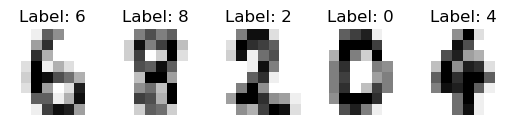

In [22]:
digits = datasets.load_digits()

inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))

# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

In [27]:
train_size = 0.8
test_size = 1 - train_size

scaler = StandardScaler()  
scaler.fit(inputs)  
inputs = scaler.transform(inputs) 

X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

In [28]:
n_hidden_neurons = 10
n_layers=0

eta = 0.001
lam = 0.001

batch_size = 100
epochs = 100

nn = NeuralNetwork(X_data=X_train, Y_data=Y_train, n_layers=n_layers, 
                 n_hidden_neurons=n_hidden_neurons, eta=eta, lam=lam)
nn.feed_forward_train(X_train)
nn.back_propagation(X_train,Y_train)

nn.train(epochs=epochs, batch_size=batch_size)
test_predict = nn.predict(X_test)
print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))

Accuracy score on test set:  0.9027777777777778


In [30]:
eta_vals = np.logspace(-5, 1, 7)
lam_vals = np.logspace(-5, 1, 7)
# store the models for later use
NN_numpy = np.zeros((len(eta_vals), len(lam_vals)), dtype=object)

# grid search
for i, eta in enumerate(eta_vals):
    for j, lam in enumerate(lam_vals):
        print("Learning rate  = ", eta)
        print("Lambda = ", lam)
        
        nn = NeuralNetwork(X_train, Y_train, eta=eta, lam=lam, 
                            n_hidden_neurons=n_hidden_neurons, n_layers=n_layers)
        nn.train(epochs=epochs, batch_size=batch_size)
        
        NN_numpy[i][j] = nn
        
        test_predict = nn.predict(X_test)
        
        print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))
        print()

Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.07777777777777778

Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.04722222222222222

Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.06666666666666667

Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.06388888888888888

Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.09166666666666666

Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.06388888888888888

Learning rate  =  1e-05
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.1361111111111111

Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.3388888888888889

Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.34444444444444444

Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.525

Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.06388888888888888

Learning rate  =  0.0001
Lambda =  0.1
Accuracy score on test set:  0.08333333333333333

Learning rate  =  0.0001
Lambda =  1.0
Accuracy score on test set:  0.11388888888888889

Learning rate  =  0.0001
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.1361111111111111

Learning rate  =  0.001
Lambda =  1e-05
Accuracy score on test set:  0.8305555555555556

Learning rate  =  0.001
Lambda =  0.0001
Accuracy score on test set:  0.8638888888888889

Learning rate  =  0.001
Lambda =  0.001
Accuracy score on test set:  0.9111111111111111

Learning rate  =  0.001
Lambda =  0.01
Accuracy score on test set:  0.5138888888888888

Learning rate  =  0.001
Lambda =  0.1
Accuracy score on test set:  0.09166666666666666

Learning rate  =  0.001
Lambda =  1.0
Accuracy score on test set:  0.09166666666666666

Learning rate  =  0.001
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.1361111111111111

Learning rate  =  0.01
Lambda =  1e-05
Accuracy score on test set:  0.9472222222222222

Learning rate  =  0.01
Lambda =  0.0001
Accuracy score on test set:  0.925

Learning rate  =  0.01
Lambda =  0.001
Accuracy score on test set:  0.9416666666666667

Learning rate  =  0.01
Lambda =  0.01
Accuracy score on test set:  0.9361111111111111

Learning rate  =  0.01
Lambda =  0.1
Accuracy score on test set:  0.48333333333333334

Learning rate  =  0.01
Lambda =  1.0
Accuracy score on test set:  0.09722222222222222

Learning rate  =  0.01
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.1361111111111111

Learning rate  =  0.1
Lambda =  1e-05
Accuracy score on test set:  0.9388888888888889

Learning rate  =  0.1
Lambda =  0.0001
Accuracy score on test set:  0.9305555555555556

Learning rate  =  0.1
Lambda =  0.001
Accuracy score on test set:  0.9555555555555556

Learning rate  =  0.1
Lambda =  0.01
Accuracy score on test set:  0.9472222222222222

Learning rate  =  0.1
Lambda =  0.1
Accuracy score on test set:  0.575

Learning rate  =  0.1
Lambda =  1.0
Accuracy score on test set:  0.14444444444444443

Learning rate  =  0.1
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


Accuracy score on test set:  0.1361111111111111

Learning rate  =  1.0
Lambda =  1e-05


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.8083333333333333

Learning rate  =  1.0
Lambda =  0.0001


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.8777777777777778

Learning rate  =  1.0
Lambda =  0.001


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.8555555555555555

Learning rate  =  1.0
Lambda =  0.01


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.7444444444444445

Learning rate  =  1.0
Lambda =  0.1


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.325

Learning rate  =  1.0
Lambda =  1.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy score on test set:  0.08333333333333333

Learning rate  =  1.0
Lambda =  10.0


/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:63: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_temp)
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/539399630.py:64: RuntimeWarning: invalid value encountered in divide
  a_temp = exp_term / (self.softmax_bound+np.sum(np.array(exp_term), axis=1, keepdims=True))


ValueError: operands could not be broadcast together with shapes (100,10) (100,9) 

/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/4_/vs3nmf594h5fk386jkh94jcc0000gn/T/ipykernel_1483/1876161919.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


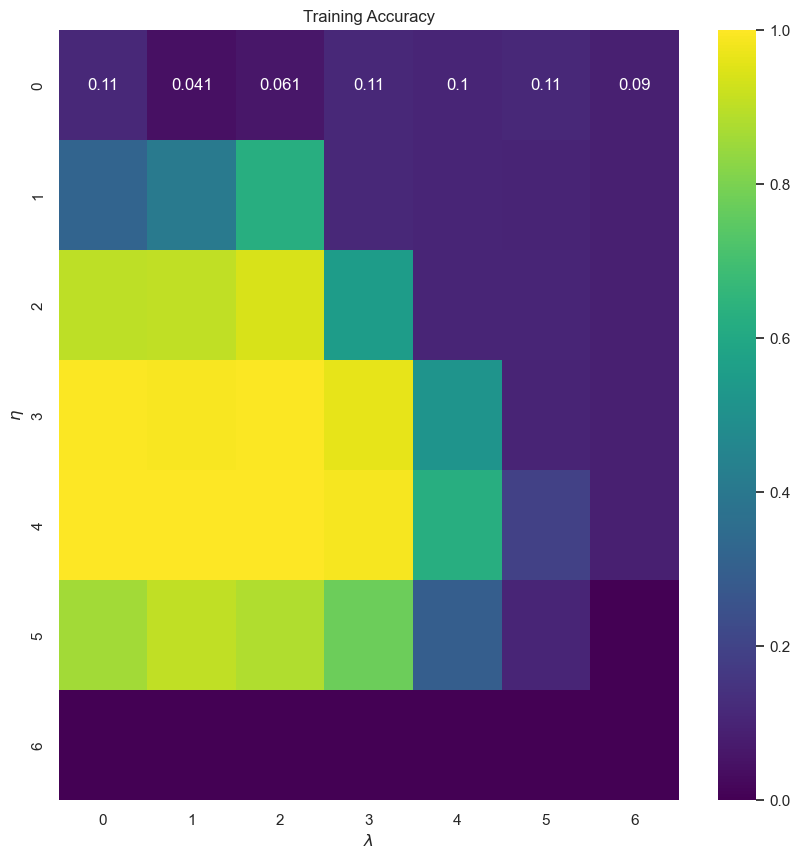

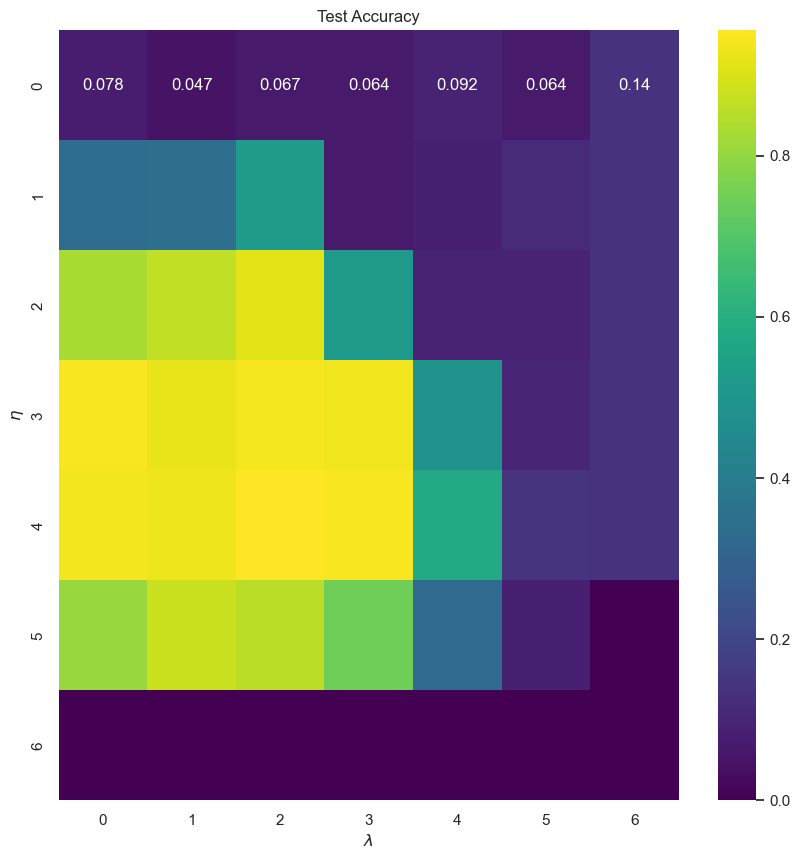

In [31]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lam_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lam_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lam_vals)):
        nn = NN_numpy[i,j]
        
        if not type(nn)==int:
            train_pred = nn.predict(X_train) 
            test_pred = nn.predict(X_test)

            train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
            test_accuracy[i][j] = accuracy_score(Y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()